In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import TargetEncoder, StandardScalar
from sklearn.linear_model import Ridge
import re

df = pd.read_csv('crime_re1.csv', index_col = 0)
df.head(2)

,Violent crime,POPESTIMATE,POPEST_MALE,POPEST_FEM,UNDER5_TOT,UNDER5_MALE,UNDER5_FEM,AGE513_TOT,AGE513_MALE,AGE513_FEM,...,Republican,Democrat,Diversity-Index,"Black or African American alone, percent, 2013","American Indian and Alaska Native alone, percent, 2013","Asian alone, percent, 2013","Native Hawaiian and Other Pacific Islander alone, percent,","Two or More Races, percent, 2013","Hispanic or Latino, percent, 2013","White alone, not Hispanic or Latino, percent, 2013"
1001,73,59759.0,29105.0,30654.0,3460.0,1797.0,1663.0,7021.0,3612.0,3409.0,...,0.52,0.35,0.388898,18.4,0.5,1.1,0.1,1.7,2.7,75.9
1003,127,246435.0,120164.0,126271.0,12470.0,6427.0,6043.0,25992.0,13286.0,12706.0,...,0.52,0.35,0.297942,9.5,0.7,0.9,0.1,1.5,4.6,83.1


## Simple Preprocessing

In [2]:
missing_value_idxs = df.index[df.isna().max(axis = 1)]
df.drop(missing_value_idxs, axis = 0, inplace = True) # This is a very bad decision, but now we are just testing models.
FIPS = df.index
df.index = np.arange(len(df))
df['Violent crime'] = df['Violent crime'].apply(lambda x: ''.join(x.split(',')))
def standardize(df): 
    for col in df: df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df
df = df.astype(float)
df.loc[:, df.columns != 'Violent crime'] = standardize(df.loc[:, df.columns != 'Violent crime'])
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X, y = df.drop('Violentcrime', axis = 1), df['Violentcrime']

C:\Users\leo\AppData\Local\Temp\ipykernel_14200\298704823.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for col in df: df[col] = (df[col] - df[col].mean()) / df[col].std()


In [3]:
# Using new df
df = pd.read_csv('crime_re2.csv', index_col = 0)
X, y = df.drop('Violentcrime', axis = 1), df['Violentcrime']

In [4]:
import seaborn as sns
sns.set_style('darkgrid')

## Cross Validation

In [5]:
def score_model(model, features, label = None, show_plot = True, save_dir = None):
  '''
  Model cv score with selected features. 
  '''
  scores = []
  oof = np.zeros_like(y)
  kf = KFold(shuffle = True, random_state = 1)
  for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train = X.loc[train_idx, features]
    X_valid = X.loc[valid_idx, features]
    y_train = y.loc[train_idx]
    y_valid = y.loc[valid_idx]

    model.fit(X_train, y_train)
    train_rmse = mean_squared_error(model.predict(X_train), y_train, squared = False)
    y_valid_pred = model.predict(X_valid)
    valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared = False)
    
    print(f"Fold {fold}: Train RMSE = {train_rmse:.3f}, Valid RMSE = {valid_rmse:.3f}")
    oof[valid_idx] = y_valid_pred
    scores.append(valid_rmse)
  
  total_rmse = sum(scores) / len(scores)
  print(f"Average RMSE: {total_rmse:.3f}")
  
  fig = None
  if show_plot:
    fig = plt.figure()
    plt.hist(y, bins = 250, alpha = 0.8)
    plt.hist(oof, bins = 100, alpha = 0.5)
    plt.xlabel('y_pred')
    plt.ylabel('count')
    plt.xlim(-50, 300)
    plt.ylim(0, 1000)
    plt.legend(['Real label dis', 'Predicted label dis'])
    plt.show()
  
  # if save_dir is not None:
    

  return total_rmse, fig
  
final_scores = []
labels = []

Fold 0: Train RMSE = 81.987, Valid RMSE = 384.898
Fold 1: Train RMSE = 172.253, Valid RMSE = 70.644
Fold 2: Train RMSE = 159.977, Valid RMSE = 186.755
Fold 3: Train RMSE = 166.531, Valid RMSE = 118.748
Fold 4: Train RMSE = 167.182, Valid RMSE = 116.977
Average RMSE: 175.604


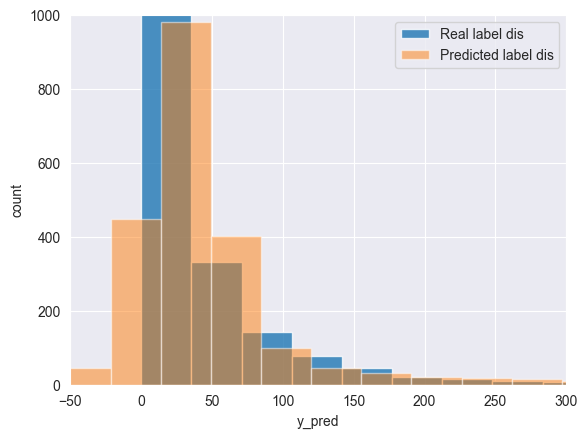

In [6]:
## Ridge
features = X.columns # a list of features to apply L1 regularization
rmse, fig = score_model(Ridge(10), features, save_dir = './figs/Ridge.png')
final_scores.append(rmse)
labels.append("Ridge")
fig.savefig('./figs/Ridge.png')

Fold 0: Train RMSE = 85.316, Valid RMSE = 423.724
Fold 1: Train RMSE = 221.667, Valid RMSE = 71.411
Fold 2: Train RMSE = 218.926, Valid RMSE = 107.396
Fold 3: Train RMSE = 220.729, Valid RMSE = 82.566
Fold 4: Train RMSE = 219.242, Valid RMSE = 103.291
Average RMSE: 157.678


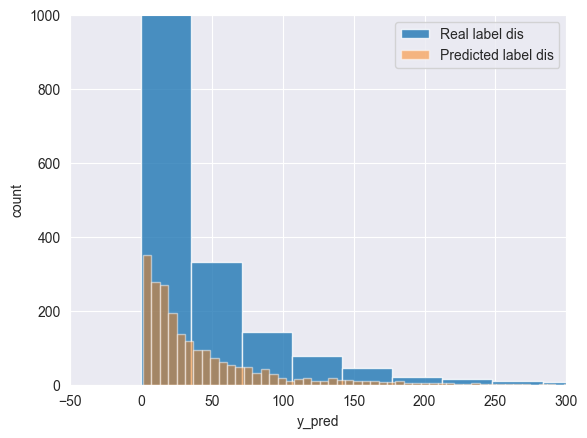

In [7]:
## RF
from sklearn.ensemble import RandomForestRegressor
param_grid_rf = {
    "n_estimators": [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False],
    "min_samples_split": [2, 5, 10]
}
# rf = RandomizedSearchCV(RandomForestRegressor(), param_grid_rf, n_iter = 80, cv = 3, verbose = 2, random_state = 42, n_jobs = -1, scoring = "neg_mean_squared_error")
# rf.fit(X,y)
rf = RandomForestRegressor(n_estimators=300, min_samples_leaf=30, random_state=42, bootstrap=True)
rmse, fig = score_model(rf, features, label = None, show_plot = True)
final_scores.append(rmse)
labels.append("Random Forest")
fig.savefig('./figs/RF.png')

Fold 0: Train RMSE = 70.298, Valid RMSE = 422.208
Fold 1: Train RMSE = 208.027, Valid RMSE = 73.346
Fold 2: Train RMSE = 206.181, Valid RMSE = 106.307
Fold 3: Train RMSE = 206.671, Valid RMSE = 88.578
Fold 4: Train RMSE = 205.968, Valid RMSE = 107.841
Average RMSE: 159.656


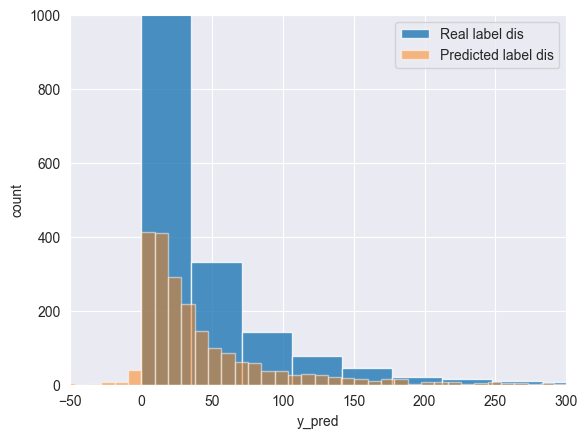

In [8]:
## lightbgm
from lightgbm import LGBMRegressor

lgbm_params = {
    'learning_rate': 0.0005,
    'n_estimators': 20000,
    'num_leaves': 7,
    'colsample_bytree': 0.4,
    'subsample': 0.5,
    'subsample_freq': 6,
    'min_child_samples': 25,
}
lgb = LGBMRegressor(**lgbm_params, random_state=42)
rmse, fig = score_model(lgb, features)
final_scores.append(rmse)
labels.append("LGBM")
fig.savefig('./figs/LGBM.png')

Fold 0: Train RMSE = 74.191, Valid RMSE = 421.386
Fold 1: Train RMSE = 208.978, Valid RMSE = 72.654
Fold 2: Train RMSE = 207.812, Valid RMSE = 105.390
Fold 3: Train RMSE = 209.122, Valid RMSE = 88.625
Fold 4: Train RMSE = 206.146, Valid RMSE = 107.539
Average RMSE: 159.119


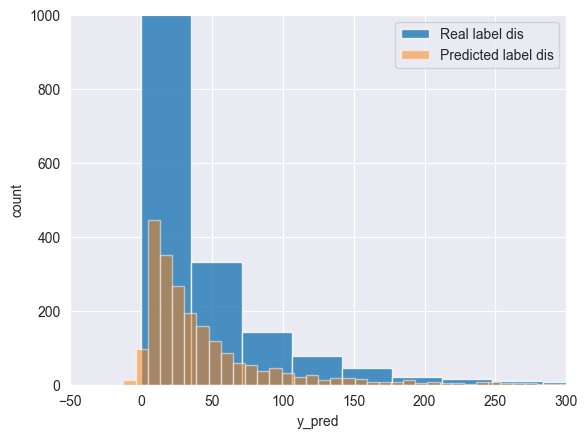

In [9]:
# gradient boosting
from sklearn.ensemble import GradientBoostingRegressor
gbr_params = {'n_estimators': 600,
    'max_depth': 4,
    'learning_rate': 0.01,
    'min_samples_leaf': 40 ,
    'max_features': 3
}
rmse, fig = score_model(GradientBoostingRegressor(**gbr_params, random_state=42), features)
final_scores.append(rmse)
labels.append("Gradient boosting")
fig.savefig('./figs/GB.png')

Fold 0: Train RMSE = 77.858, Valid RMSE = 409.248
Fold 1: Train RMSE = 191.290, Valid RMSE = 64.320
Fold 2: Train RMSE = 185.192, Valid RMSE = 114.462
Fold 3: Train RMSE = 188.476, Valid RMSE = 84.026
Fold 4: Train RMSE = 187.274, Valid RMSE = 100.729
Average RMSE: 154.557


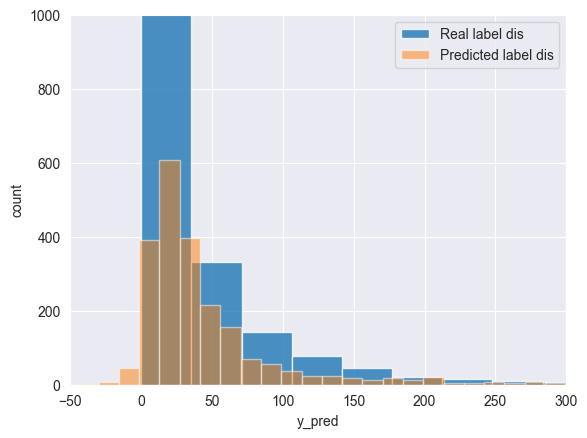

In [10]:
#Ensemble 1
from sklearn.ensemble import VotingRegressor
ensemble_model = VotingRegressor([('gb', GradientBoostingRegressor(**gbr_params, random_state=42)),
                                  ('rf', RandomForestRegressor(n_estimators=300, min_samples_leaf=30, random_state=42)),
                                  ('ridge', Ridge(10))],
                                 weights=[1/3, 1/3, 1/3])
rmse, fig = score_model(ensemble_model,features)
final_scores.append(rmse)
labels.append("GB + RF + Ridge")
fig.savefig('./figs/Ensemble1.png')

Fold 0: Train RMSE = 75.507, Valid RMSE = 412.366
Fold 1: Train RMSE = 194.353, Valid RMSE = 65.121
Fold 2: Train RMSE = 189.374, Valid RMSE = 109.409
Fold 3: Train RMSE = 192.004, Valid RMSE = 83.075
Fold 4: Train RMSE = 191.025, Valid RMSE = 101.403
Average RMSE: 154.275


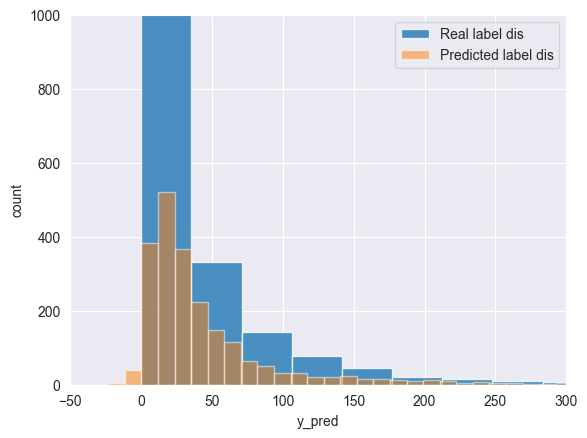

In [11]:
# Ensemble 2
from sklearn.ensemble import VotingRegressor
ensemble_model = VotingRegressor([('gb', GradientBoostingRegressor(**gbr_params, random_state=42)),
                                  ('rf', RandomForestRegressor(n_estimators=300, min_samples_leaf=30, random_state=42)),
                                  ('ridge', Ridge(10)),
                                  ('lgbm', LGBMRegressor(**lgbm_params, random_state=1))],
                                 weights=[1/4, 1/4, 1/4, 1/4])
rmse, fig = score_model(ensemble_model,features)
final_scores.append(rmse)
labels.append("GB + RF + Ridge + LGBM")
fig.savefig('./figs/Ensemble2.png')

Fold 0: Train RMSE = 83.598, Valid RMSE = 427.825
Fold 1: Train RMSE = 236.519, Valid RMSE = 58.368
Fold 2: Train RMSE = 217.739, Valid RMSE = 117.915
Fold 3: Train RMSE = 236.270, Valid RMSE = 67.796
Fold 4: Train RMSE = 221.276, Valid RMSE = 107.701
Average RMSE: 155.921


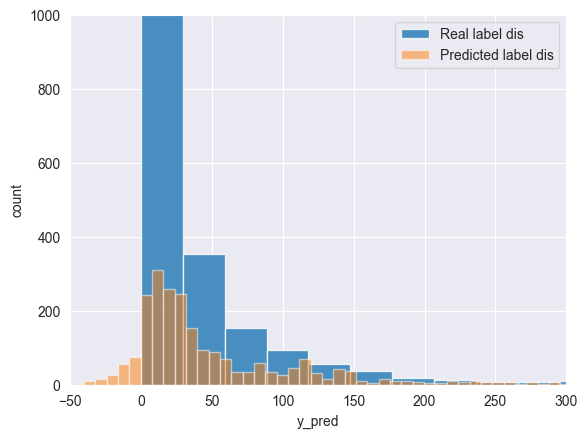

In [12]:
#XGBRegressor
from xgboost import XGBRegressor
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42, eval_metric="rmse", 
    early_stopping_rounds = 25)

scores = []
oof = np.zeros_like(y)
kf = KFold(shuffle = True, random_state = 1, n_splits=5)
for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train = X.loc[train_idx, features]
    X_valid = X.loc[valid_idx, features]
    y_train = y.loc[train_idx]
    y_valid = y.loc[valid_idx]

    model.fit(X_train, y_train,  
    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
    verbose=False)

    train_rmse = mean_squared_error(model.predict(X_train), y_train, squared = False)
    y_valid_pred = model.predict(X_valid)
    valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared = False)

    print(f"Fold {fold}: Train RMSE = {train_rmse:.3f}, Valid RMSE = {valid_rmse:.3f}")
    oof[valid_idx] = y_valid_pred
    scores.append(valid_rmse)

total_rmse = sum(scores) / len(scores)
print(f"Average RMSE: {total_rmse:.3f}")

plt.hist(y, bins = 300, alpha = 0.8)
plt.hist(oof, bins = 50, alpha = 0.5)
plt.xlabel('y_pred')
plt.ylabel('count')
plt.xlim(-50, 300)
plt.ylim(0, 1000)
plt.legend(['Real label dis', 'Predicted label dis'])
final_scores.append(total_rmse)
labels.append("Xgboost")
plt.savefig('./figs/xgboost.png')

,label,rmse
5,GB + RF + Ridge + LGBM,154.274867
4,GB + RF + Ridge,154.556900
6,Xgboost,155.920969
1,Random Forest,157.677544
3,Gradient boosting,159.119034
2,LGBM,159.655847
0,Ridge,175.604437


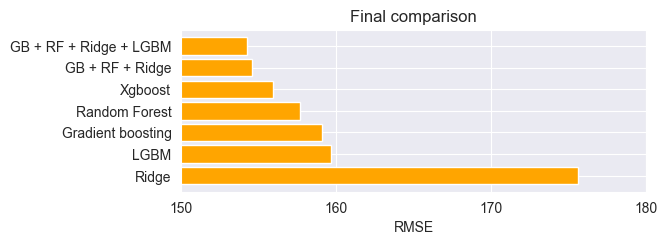

In [13]:
comparison = pd.DataFrame({"label": labels, "rmse": final_scores})
comparison.drop_duplicates(subset='label', keep='last', inplace=True)
comparison.sort_values('rmse', inplace=True)
display(comparison[['label', 'rmse']])
plt.figure(figsize=(6, len(comparison) * 0.3))
plt.title('Final comparison')
plt.barh(np.arange(len(comparison)), comparison.rmse, color='orange')
plt.gca().invert_yaxis()
plt.yticks(np.arange(len(comparison)), comparison.label)
plt.xticks(np.linspace(150, 180, 4))
plt.xlabel('RMSE')
plt.xlim(150, 180)
plt.savefig('comparison.png')